# Overview
In this notebook, we'll put together all of the NLP tools we've learned and apply them to several clinical problems:

1. Detecting evidence of surgical site infections (SSIs) and body location
2. Identify texts with positive COVID-19 cases
3. Apply our NLP pipeline to MIMIC data and analyze the results using pandas

In [1]:
import spacy
import medspacy

from medspacy.ner import TargetRule
from medspacy.context import ConTextItem
from medspacy.visualization import visualize_ent, visualize_dep

## Choice of Model
For Tasks #1-2, which are short and include very specific concepts, we'll load a blank model and add target rules to match the concepts. Task #3 is quite long and will include many different concepts. This is exactly the kind of scenario when we would want to use a pre-trained machine learning model.

In [2]:
nlp = medspacy.load()
# nlp = medspacy.load("en_info_3700_i2b2_2012")

In [3]:
nlp.pipe_names

['tagger',
 'parser',
 'target_matcher',
 'sectionizer',
 'context',
 'postprocessor']

In [4]:
target_matcher = nlp.get_pipe("target_matcher")
context = nlp.get_pipe("context")

# I. Surgical site infection
Patient safety measures require identifying adverse outcomes of medical treatment, such as surgical site infections (SSIs). In this exercise, we will identify evidence of SSIs from radiology exams. 

- Add target rules to match any mention of evidence of SSI such as **"fluid collection"** or **"abscess"**
- Add target rules to match any body location
- Add context rules to identify any additional modifiers, such as negation or uncertainty

See this manuscript: [Detecting Evidence of Intra-abdominal Surgical Site Infections From Radiology Reports Using Natural Language Processing](https://pubmed.ncbi.nlm.nih.gov/29854116/)

In [5]:
texts = [
    "Fluid collection is seen in the abdomen.",
    "There is no evidence of fluid collection.",
    "PURPOSE OF EXAM: Rule out abscess.",
    "Hematomas are seen around in the right lower quadrant.",
    "No drainable collection is noted at this time.",
    "Post-surgical enhancing fluid collections, most notable right lower quadrant and left pelvis.",
    "please assess for possible ir drainage if abscess present.",
    "Intraloop fluid collection with air-fluid level, might represent contained rupture or intraloop abscess.",
    "No evidence of intra-abdominal abscess.",
    "Right paracolic and anterior abdominal fluid collections with rim enhacement likely representing abscesses amenable to drainage.",
    "r/o infiltrate, fluid collection",
    "No fluid collection is identified within the abdomen and pelvis.",
    "no fluid collection is seen around the anastamosis site",
    "36 year old woman with nectrotzing pancreatitis and intraabdominal collections.",
    "REASON FOR THIS EXAMINATION: CT abd/pelvis to access for dihiscence or abcess / fluid collection.",
]

In [6]:
target_rules = [
    TargetRule("fluid collection", "SSI"),
    TargetRule("hematoma", "SSI", pattern=[{"LOWER": {"REGEX": "hematoma"}}]),
    TargetRule("abscess", "SSI"),
    TargetRule("abdomen", "BODY_LOC", pattern=[{"LOWER": {"REGEX": "abd(omen)?"}}]),
    TargetRule("<LEFT/RIGHT> <UPPER/LOWER> quadrant", "BODY_LOC",
              pattern=[
                  {"LOWER": {"IN": ["left", "right"]}},
                  {"LOWER": {"IN": ["upper", "lower"]}},
                  {"LOWER": "quadrant"}
              ]),
]

In [7]:
target_matcher.add(target_rules)

In [8]:
context_item_data = [
    
]

In [9]:
context.add(context_item_data)

In [10]:
docs = list(nlp.pipe(texts))

Now scroll through the results and see if you extracted all of the relevant information. If your model misses any, go back and add them to your rules.

In [11]:
idx = 0

In [12]:
visualize_ent(docs[idx])

In [13]:
visualize_dep(docs[idx])

# II. COVID-19
In this exercise, we will look for evidence of COVID-19 from clinical text. See this manuscript describing a similar like this: [A Natural Language Processing System for National
COVID-19 Surveillance in the US Department of Veterans Affairs](https://openreview.net/pdf?id=ZQ_HvBxcdCv)

- Add target rules to extract any mentions of COVID-19 or synonyms
- Add context rules to identify any modifiers such as **"NEGATED_EXISTENCE"**, **"UNCERTAIN"**, or **"POSITIVE_EXISTENCE"** (ie, "confirmed" or "diagnosed with")


In [17]:
nlp = medspacy.load()
target_matcher = nlp.get_pipe("target_matcher")

In [18]:
texts = [
    "Patient admitted to hospital for respiratory failure secondary to COVID-19.",
    "The patient reports that they have been diagnosed with COVID-19",
    "Requested that patient be screened for novel coronavirus via telephone",
    "Lab Results: SARS-COV-2 DETECTED",
    "Patient does not have COVID-19",
    "This encounter is done over the telephone secondary to COVID-19 precautions.",
    
]

In [19]:
target_matcher = nlp.get_pipe("target_matcher")
context = nlp.get_pipe("context")

In [20]:
target_rules = [
    TargetRule("COVID-19", "COVID-19"),
    TargetRule("SARS-COV-2", "COVID-19"),
    TargetRule("novel coronavirus", "COVID-19"),
]

In [21]:
target_matcher.add(target_rules)

In [22]:
context = nlp.get_pipe("context")

In [23]:
item_data = [
    ConTextItem("admitted to hospital for", "POSITIVE_EXISTENCE", rule="FORWARD"),
    ConTextItem("diagnosed with", "POSITIVE_EXISTENCE", rule="FORWARD"),
    ConTextItem("secondary to", "POSITIVE_EXISTENCE", rule="FORWARD"),
    ConTextItem("screened for", "UNCERTAIN", rule="FORWARD"),
    ConTextItem("DETECTED", "POSITIVE_EXISTENCE", rule="BACKWARD"),
    ConTextItem("precautions", "HYPOTHETICAL", rule="BIDIRECTIONAL"),
]

In [24]:
context.add(item_data)

In [25]:
docs = list(nlp.pipe(texts))

In [26]:
idx = 1

In [27]:
visualize_ent(docs[idx])

In [28]:
visualize_dep(docs[idx])

# III. Process full documents from MIMIC-II
In this exercise,  We will then take our extracted entities, convert them into structured data, and analyze the results using pandas.

Now that you've fine-tuned and improved your model, we're ready to run it on the entire dataset and analyze it! In this step, we'll show how you can use NLP to convert text to **structured** data, which you can then analyze in the same way that we previously analyzed structured EHR data like **labs** and **vitals**. We'll first apply our NLP system to a large corpus of discharge summaries from MIMIC-II. Then we'll extract all of the entities from our docs and convert them into a pandas DataFrame.

In [43]:
# Load our machine learning model
nlp = medspacy.load("en_info_3700_i2b2_2012")

In [44]:
nlp.pipe_names

['tagger',
 'parser',
 'ner',
 'target_matcher',
 'sectionizer',
 'context',
 'postprocessor']

In [45]:
ner = nlp.get_pipe("ner")

In [46]:
ner.labels

('PROBLEM', 'TEST', 'TREATMENT')

In [47]:
target_matcher = nlp.get_pipe("target_matcher")

In [38]:
import pymysql
import getpass

In [41]:
conn = pymysql.connect(host="35.233.174.193",port=3306,
                           user=getpass.getpass("Enter username for MIMIC2 database"),
                           passwd=getpass.getpass("Enter password for MIMIC2 database"),
                           db='mimic2')

Enter username for MIMIC2 database········
Enter password for MIMIC2 database········


In [42]:
import pandas as pd

### TODO
Change the query below to pull as many documents as you like. Using more documents will give you more interesting and relevant results, but will also take longer to process with `nlp`. I recommend using 100-1000.

In [48]:
query = """

SELECT subject_id, text
FROM noteevents
WHERE category = 'DISCHARGE_SUMMARY'
LIMIT 10;

"""
df = pd.read_sql(query, conn)

In [49]:
df.head()

,subject_id,text
0,56,\n \n \n \nAdmission Date: [**2644-1-17**] ...
1,37,\n\n\nAdmission Date: [**3264-8-14**] Dis...
2,78,\n\nAdmission Date: [**2778-3-24**] Dis...
3,26,\n\nAdmission Date: [**3079-3-3**] Discha...
4,12,\n\n\nAdmission Date: [**2875-9-26**] Dis...


In [50]:
%%time
docs = list(nlp.pipe(df["text"]))

CPU times: user 8.17 s, sys: 734 ms, total: 8.9 s
Wall time: 11.3 s


In [51]:
doc = docs[0]

In [52]:
visualize_ent(doc)

## Convert to structured data
The function below will take the attributes of an entity and return a dictionary. We can then take a list of dictionaries and convert them to a pandas DataFrame.

In [54]:
def ent_to_dict(ent):
    d = {}
    d["text"] = ent.lower_
    d["label"] = ent.label_
    d["sent"] = ent.sent.text
    
    # ConText attributes
    d["is_negated"] = ent._.is_negated
    d["is_historical"] = ent._.is_historical
    d["is_uncertain"] = ent._.is_uncertain
    d["is_family"] = ent._.is_family
    d["is_hypothetical"] = ent._.is_hypothetical
    
    # Section
    d["section_title"] = ent._.section_title
    
    return d

In [60]:
ents_data = []
for doc in docs:
    for ent in doc.ents:
        ents_data.append(ent_to_dict(ent))

In [61]:
ents_df = pd.DataFrame(ents_data)

In [62]:
ents_df.head()

,text,label,sent,is_negated,is_historical,is_uncertain,is_family,is_hypothetical,section_title
0,known allergies,PROBLEM,Patient recorded as having No Known Allergies ...,True,False,False,False,False,allergies
1,drugs,TREATMENT,Patient recorded as having No Known Allergies ...,True,False,False,False,False,allergies
2,invasive procedure,TREATMENT,Major Surgical or Invasive Procedure:\n,False,False,False,False,False,chief_complaint
3,age,TREATMENT,**Age over 90,False,False,False,False,False,chief_complaint
4,lung ca,PROBLEM,w/ h/o \nlung ca w/ metastasis to brain on XRT,False,True,False,False,False,chief_complaint


We'll import some visualization modules to visualize our results.

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline

In [67]:
import seaborn as sns
sns.set()

## Question #1: What is the distribution of entity labels?
Generate the count of values in the **"label"** column. Then plot these values as a bar plot to compare.

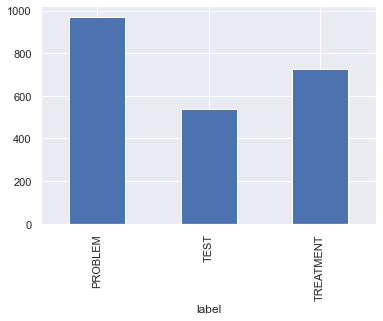

In [65]:
ents_df.groupby("label").size().plot.bar()

## Question #2: What problems occur most often in the PMH?
Use pandas filtering to filter to rows where the section title is **"past medical history"** and the label is **"PROBLEM"**. Then use the `value_counts()` method to get counts of values in the **"text"** column. Then sort the values to see what the most common historical conditions are.

### Bonus
Plot the top 10 PMH problems.

In [77]:
# First, filter to rows where "label" == "PROBLEM"
pmh = ents_df[ents_df["label"] == "PROBLEM"]

In [78]:
# Now filter to rows where the section_title is "past_medical_history" 
pmh = pmh[pmh["section_title"] == "past_medical_history"]

In [79]:
# Now get the counts of values in the "text" column
pmh = pmh["text"].value_counts()

In [80]:
pmh.head(10)

hypertension                5
depression                  3
hodgkin's disease           3
coronary artery disease     3
congestive heart failure    2
gastrointestinal bleed      2
hiv                         2
cva                         2
hypercholesterolemia        2
t cell lymphoma             2
Name: text, dtype: int64

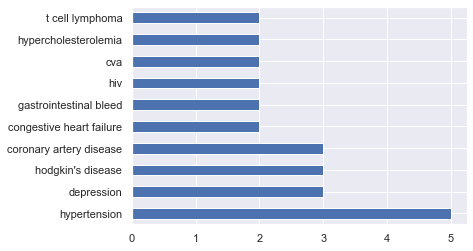

In [83]:
ax = pmh.head(10).plot.barh()

## Question #3: What problems occur most often in the family history?
Filter the dataframe to see which problems occur most often in a patient's family history. This can be either:
- The problem occured in the **"family_history"** section; or
- The problem has a context attribute of **"is_family" == True**

Then sort to find which problems occur most frequently in family history.

### Bonus
Plot the top 10 FH problems.

In [85]:
# First, filter to rows where "label" == "PROBLEM"
fh = ents_df[ents_df["label"] == "PROBLEM"]

In [86]:
# Now, filter to rows where is_family is True or section_title = "family_history"
fh = fh[(fh["is_family"] == True) | (fh["section_title"] == "family_history")]

In [87]:
fh.head()

,text,label,sent,is_negated,is_historical,is_uncertain,is_family,is_hypothetical,section_title
182,coronary artery disease,PROBLEM,Family history was noncontributory for\ncorona...,False,True,False,True,False,family_history
442,c cirrhosis,PROBLEM,The patient\nfalls between Child Class B and C...,False,False,False,True,False,past_medical_history
483,diabetes\nmellitus,PROBLEM,"The patient's father is 82 years old, sufferin...",False,False,False,True,False,family_history
485,cancer,PROBLEM,The patient has two sisters who have died of\n...,False,False,False,True,False,family_history
486,substance abuse,PROBLEM,There is no family history of substance abuse.,True,True,False,True,False,family_history


In [88]:
# Now get the distinct counts
fh = fh["text"].value_counts()

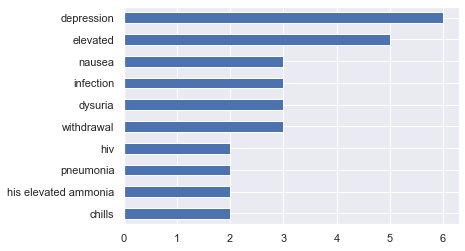

In [90]:
ax = fh.head(10).plot.barh()
ax.invert_yaxis()